In [1]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from tqdm import tqdm
import xarray as xr 
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal

In [2]:
small_action_dict = {
    0: {"name":"Up", "label":"↑", "delta":(-1,0), 'angle': np.pi},
    1: {"name":"Right", "label":"→", "delta":(0,1), 'angle': (3 * np.pi / 2)},
    2: {"name":"Down", "label":"↓", "delta":(1,0), 'angle': 0},
    3: {"name":"Left", "label":"←", "delta":(0,-1), 'angle': (np.pi / 2)},}

In [3]:
color_dict = {
    '0': colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:ultramarine"]),
    '1': colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:magenta"]),
}

In [7]:
class GridPlotter:
    def __init__(self, agent):
        self.agent = agent

    def plot_env(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.1 * self.agent.width, 0.1 * self.agent.height))
        ax.imshow(1 - self.agent.grid, cmap=cm.binary, zorder=1, alpha=0.25) #, extent=[-0.5, self.agent.width - 0.5, -0.5, self.agent.height - 0.5])
        ax.imshow((color_dict['0'](self.agent.env[:,:,0]) + color_dict['1'](self.agent.env[:,:,1]))/2, interpolation='gaussian', zorder=0) #, extent=[-0.5, self.agent.width - 0.5, -0.5, self.agent.height - 0.5])
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xlim([self.agent.pk_hw - 1, self.agent.width - self.agent.pk_hw])
        ax.set_ylim([self.agent.height - self.agent.pk_hw, self.agent.pk_hw - 1])
        return ax 
    
    def plot_rewards(self, ax):
        for reward, reward_value in zip(self.agent.reward_locations, self.agent.reward_values):
            reward_patch = plt.Circle(reward[::-1], 0.5, color='orange', zorder=2)
            ax.add_patch(reward_patch)
            ax.text(reward[1], reward[0], "R", color='white', weight="bold", fontsize=4, ha='center', va='center', alpha=0.5)
        return ax

    def plot_agent(self, ax, agent_location, size_scaler=1):
        agent_patch = plt.Circle(agent_location, 0.5 * size_scaler, color='blue', zorder=3)
        ax.add_patch(agent_patch)
        return ax

    def render(self, agent_location, agent_direction):
        ax = self.plot_env(ax)
        ax = self.plot_rewards(ax)
        ax = self.plot_agent(ax, agent_location, agent_direction)
        plt.show()

    def plot_episode(self, episode_data, stop_at_step=None, ax=None):
        locations = episode_data["locations"]
        actions = episode_data["actions"]
        stop_at_step = len(locations) if stop_at_step is None else stop_at_step
        
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)
            
        for i in range(stop_at_step):
            ax = self.plot_agent(ax, agent_location=locations[i], agent_direction=actions[i], size_scaler=(1 + (i / len(locations)) / 2))
            if i > 0:
                ax.plot([locations[i-1][0], locations[i][0]], [locations[i-1][1], locations[i][1]], color=plt.cm.viridis(1 - episode_frac), alpha=(1 + episode_frac) / 2, linewidth=0.5)
        return ax

    def plot_training_progress(self, episode_lengths, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        n_eps = len(episode_lengths)
        smoothed_episode_lengths = [np.mean(episode_lengths[max(0, i - 100):i + 1]) for i in range(n_eps)]
        ax.scatter(np.arange(n_eps), episode_lengths, linewidth=0, alpha=0.5, c='C0', label="Episode length")
        ax.plot(np.arange(len(smoothed_episode_lengths)), smoothed_episode_lengths, color='k', linestyle="--", linewidth=0.5, label="Smoothed")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Length")
        ax.legend()
        ax.set_title("Training Progress")
        return ax

    def plot_policy(self, ax=None):
        if ax is None:
            ax = self.plot_env()
            ax = self.plot_rewards(ax)

        for state, location in enumerate(self.agent.valid_states):
            action = np.argmax(self.agent.Q_value(state))
            color = plt.colormaps['twilight'](action / self.agent.n_actions)
            ax = self.plot_arrow(location[::-1], action, ax, color=color, size_scaler=0.5)
        return ax

    def plot_arrow(self, location, direction, ax, **kwargs):
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0.5))
        size_scaler = kwargs.get("size_scaler", 1)
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]]) - np.array([0.5, 0.5])
        scaled_triangle = base_triangle * size_scaler
        angle = self.agent.action_dict[direction]['angle']
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)
        translated_triangle = rotated_triangle + np.array(location)
        triangle = plt.Polygon(translated_triangle, color=color, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax

In [8]:
class QLearnerAgent:
    def __init__(self, env, pk_hw, gamma, alpha, epsilon, n_features, max_steps, cost_per_step, cost_per_wall_collision, reward_locations, reward_values, action_dict=small_action_dict):
        self.env = env
        self.grid = env[:, :, -1]
        self.pk_hw = pk_hw
        self.height, self.width = self.grid.shape
        self.max_steps = max_steps
        self.cost_per_step = cost_per_step
        self.cost_per_wall_collision = cost_per_wall_collision
        self.reward_locations = reward_locations
        self.reward_values = reward_values
        
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        
        self.valid_states = self.get_valid_states()
        self.action_dict = action_dict
        self.n_features = n_features
        self.n_states = len(self.valid_states)
        self.n_actions = len(action_dict)
        self.theta = np.zeros((self.n_states, self.n_actions))

        self.plotter = GridPlotter(self)
        self.reset()

    def reset(self):
        self.agent_location = self.valid_states[np.random.randint(len(self.valid_states))]
        self.agent_direction = 0
        
    def get_valid_states(self):
        return [(r, c) for r in range(self.height) for c in range(self.width) if not self.collision((r, c))]

    def get_features(self, state):
        features = np.zeros((self.n_features, self.n_states))
        if state is not None:
            features[0][state] = 1
        
            location = self.valid_states[state]
            features[1][state] = self.env[location[0], location[1], 0]
        return features

    def Q_value(self, state):
        return np.dot(self.get_features(state)[0], self.theta)
    
    def learn(self, state, next_state, A, next_action, R):
        Q = 0 if state is None else self.Q_value(state)[A]
        Q_next =  0 if (next_state is None or next_action is None) else self.Q_value(next_state)[next_action]
        TD_error = R + self.gamma * Q_next - Q
        if state is not None:
            self.theta[:, A] += self.alpha * TD_error * self.get_features(state)[0]
        return TD_error

    def step(self, action):
        next_location = tuple(np.array(self.agent_location) + self.action_dict[action]['delta'])
        reward = self.get_reward(next_location) - self.cost_per_step

        if not self.collision(next_location):
            self.agent_location = next_location
            self.agent_direction = action
        else:
            reward -= self.cost_per_wall_collision

        return self.location_to_state(self.agent_location), reward, (reward > 0)

    def collision(self, location):
        return 1 if self.grid[location[0], location[1]] == 0 else 0

    def get_reward(self, location):
        return self.reward_values[self.reward_locations.index(location)] if location in self.reward_locations else 0

    def location_to_state(self, location):
        return self.valid_states.index(location) if location in self.valid_states else None

    def epsilon_greedy_policy(self, state, epsilon):
        return np.random.randint(self.n_actions) if np.random.rand() < epsilon else np.argmax(self.Q_value(state))
    
    def train(self, n_episodes, max_episode_length=None):
        self.episode_history = {}
        self.episode_lengths = []
        max_episode_length = self.max_steps if max_episode_length is None else max_episode_length
        
        for episode in tqdm(range(n_episodes)):
            self.reset()
            state = self.location_to_state(self.agent_location)
            action = self.epsilon_greedy_policy(state, self.epsilon)
            episode_data = {'locations': [], 'states': [], 'actions': [], 'rewards': []}
            terminal = False
            step = 0

            while not terminal and step < max_episode_length:
                state_next, reward, terminal = self.step(action)
                next_action = self.epsilon_greedy_policy(state_next, self.epsilon) if not terminal else None
                self.learn(state, state_next, action, next_action, reward)

                episode_data['locations'].append(self.agent_location)
                episode_data['states'].append(state)
                episode_data['actions'].append(action)
                episode_data['rewards'].append(reward)

                state = state_next
                action = next_action
                step += 1

                self.update_parameter(self.alpha, 0.99, 0.01)
                self.update_parameter(self.epsilon, 0.9, 0.01)

            self.episode_history[episode] = episode_data
            self.episode_lengths.append(step)

    def update_parameter(self, parameter, decay_rate, parameter_min):
        max(parameter * decay_rate, parameter_min)

    def produce_plots(self, training, policy):
        if training:
            self.plotter.plot_training_progress(episode_lengths=self.episode_lengths)
        if policy:
            self.plotter.plot_policy()

In [9]:
width=21
height=21
pk = 30
pk_hw = 15

env = np.zeros((height, width, 3))
for r in range(height):
    for c in range(width):
        if r < 2:  
            env[r, c, -1] = 1.0
        elif c >= (r - 1) and c < width - (r - 1):
            env[r, c, -1] = 1.0
env = np.pad(env, pad_width=((pk_hw, pk_hw), (pk_hw, pk_hw), (0, 0)))

reward_locations = ((pk_hw), pk_hw) # (width + pk) // 2)

k1d = signal.windows.gaussian(pk, std=6)
k2d = np.outer(k1d, k1d)
r, c = reward_locations
cue_top = r - pk_hw
cue_bottom = r + pk_hw
cue_left = c - pk_hw
cue_right = c + pk_hw
env[cue_top: cue_bottom, cue_left: cue_right, 0] += k2d[:cue_bottom - cue_top, :cue_right - cue_left] * env[cue_top: cue_bottom, cue_left: cue_right, -1]


In [10]:
agent = QLearnerAgent(
    env = env,
    pk_hw = pk_hw,
    max_steps=100,
    reward_locations = [reward_locations],
    reward_values = [50],
    cost_per_step=1,
    cost_per_wall_collision=1,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.05,
    n_features=2,
)

In [11]:
agent.train(
    n_episodes = 10000,
)

100%|██████████| 10000/10000 [00:02<00:00, 3681.73it/s]


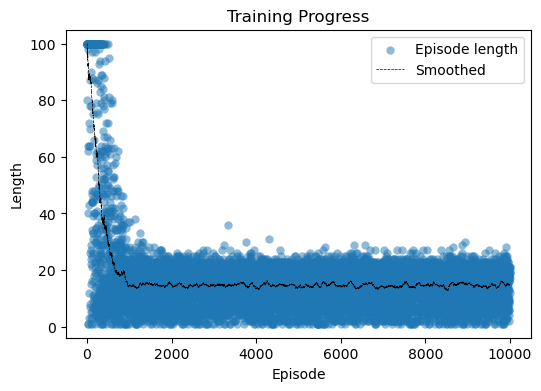

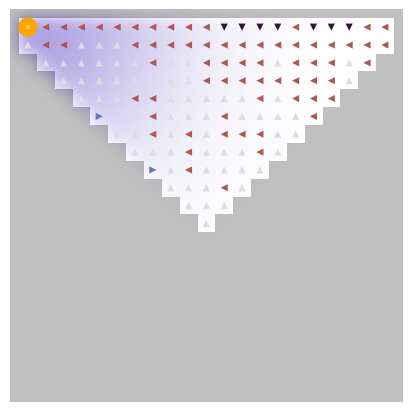

In [12]:
agent.produce_plots(training=True, policy=True)

[]

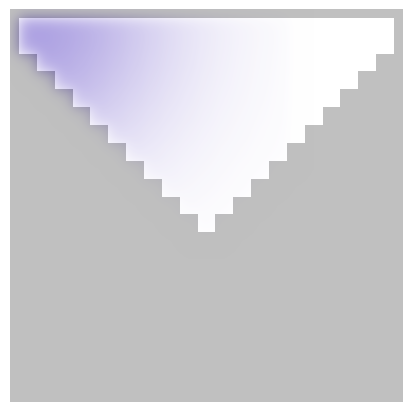

In [13]:
ax = agent.plotter.plot_env()
ax.plot()